In [2]:
import cftime
from datetime import timedelta
from datetime import datetime
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy import signal

%matplotlib widget

In [4]:
# Load mission 19 data and plot tracks over the radar image
mission_nc_path = '../../microSWIFT_data/final_dataset/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Load the breaker dataset
breaker_df = pd.read_csv('../../microSWIFT_data/breaker_df.csv')
breaker_df_mission19 = breaker_df[breaker_df['mission number'] == 19]

# Plot the microSWIFT tracks over the radar image
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
vertical_accel = np.ma.masked_invalid(mission_dataset['acceleration_z_body'])
velocity_ew = np.ma.masked_invalid(mission_dataset['velocity_ew'])
time_vals = mission_dataset['time'][:]

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_30037/1412478412.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_30037/1412478412.py:18: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.g

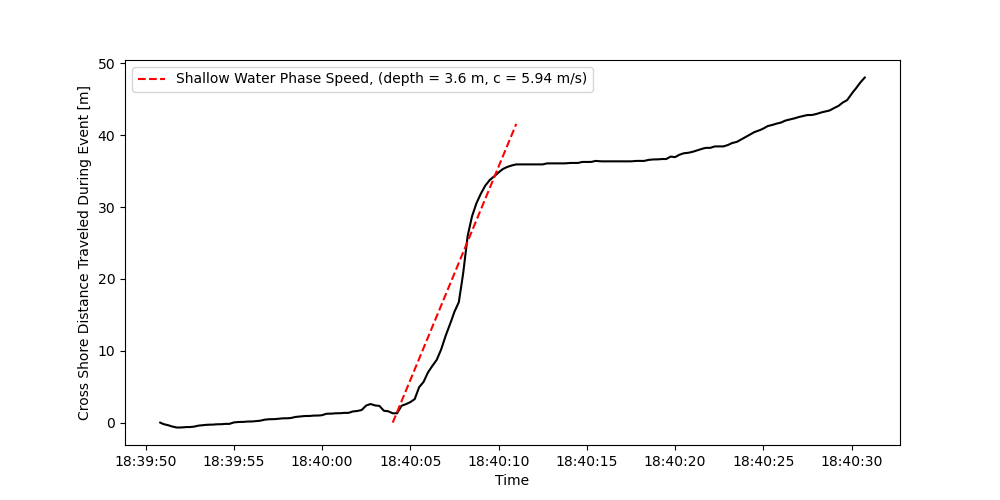

In [32]:
# Plot the time series of cross shore and along shore location with the breaking events
trajectory_num = 5
example_trajectory_df = breaker_df_mission19[breaker_df_mission19['trajectory number'] == trajectory_num]

time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Convert times to actual datetimes
example_trajectory_df['time'] = pd.to_datetime(example_trajectory_df['time'])
breaking_event_times = example_trajectory_df['time'].tolist()

# breaking event depth
bathy_file = '../../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
bathy = bathy_dataset['elevation'][0,:,:]
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy_f = interpolate.interp2d(xFRF_grid, yFRF_grid, bathy)
breaking_depth = bathy_f(example_trajectory_df['cross shore location [m]'].iloc[0],
                          example_trajectory_df['along shore location [m]'].iloc[0]).item()

# phase speed for breaking 
c_breaking = np.sqrt(9.8 * np.abs(breaking_depth)) 
seconds_phase_speed = np.linspace(0, 7, 15)
distance_traveled_at_phase_speed = (c_breaking * seconds_phase_speed) # offset for fitting to the plot
t = pd.date_range(start='2021-10-08T18:40:04',
                  end='2021-10-08T18:40:11',
                  periods=15)


fig, ax1 = plt.subplots(figsize=(10,5))

# Cross Shore Distance
time_ind = 15730
ax1.plot(time[time_ind:time_ind+480], x_locations[trajectory_num,time_ind] - x_locations[trajectory_num,time_ind:time_ind+480], color='k')
ax1.plot(t.values, distance_traveled_at_phase_speed, color='r', linestyle='dashed', 
         label=f'Shallow Water Phase Speed, (depth = {np.round(np.abs(breaking_depth), 2)} m, c = {np.round(c_breaking, 2)} m/s)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cross Shore Distance Traveled During Event [m]', color='k')

ax1.legend()

(17, 20161)

In [24]:
40*12

480